# BREATHING WAVE
## DEEP LEARNING - LSTM
### 04 March 2023

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

df = pd.read_csv("breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")

In [2]:
df

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,labels
0,0.483309,0.459790,0.431024,0.376565,0.295734,0.193290,0.066060,-0.083445,-0.247221,-0.409374,...,0.391514,0.452677,0.521407,0.595845,0.661691,0.702932,0.708613,0.682564,0.637765,deep
1,-2.044518,-1.935588,-1.808629,-1.667919,-1.513497,-1.348760,-1.171044,-0.972509,-0.759554,-0.547793,...,0.138731,-0.053860,-0.241691,-0.417603,-0.582320,-0.738485,-0.889731,-1.037066,-1.174654,deep
2,-1.213535,-1.269056,-1.323306,-1.375251,-1.430062,-1.485479,-1.529200,-1.557172,-1.574662,-1.575457,...,0.947940,0.996154,1.035743,1.049543,1.024204,0.954716,0.844505,0.702445,0.541555,deep
3,-0.914806,-0.887726,-0.856065,-0.823527,-0.794551,-0.768074,-0.740895,-0.713364,-0.685445,-0.652020,...,-0.478218,-0.571465,-0.684115,-0.817078,-0.966231,-1.122537,-1.264759,-1.376908,-1.461059,deep
4,-1.547469,-1.458818,-1.362120,-1.264829,-1.164948,-1.060064,-0.954496,-0.849448,-0.742812,-0.636614,...,0.227050,0.130983,0.041438,-0.038034,-0.106152,-0.163048,-0.210926,-0.253102,-0.290270,deep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26395,-0.152463,-0.164723,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,...,-0.336787,-0.306774,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,quick
26396,-0.164723,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,...,-0.306774,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958,quick
26397,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,0.240939,...,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958,0.179209,quick
26398,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,0.240939,0.294399,...,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958,0.179209,0.264014,quick


## Augmented Data (UP & DOWN 0.01)
### Current Shape now  : 26400 x 3 = 79200

In [3]:
up = df
down = df
up.iloc[:, :-1] += 0.01
down.iloc[:, :-1] -= 0.01
df = pd.concat([df, up, down], ignore_index=True)

In [4]:
df.shape

(79200, 86)

In [5]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

# Check if the data do not have any NULL 
print("X have a null? \t{}".format(X.isnull().values.any()))
print("Y have a null? \t{}".format(Y.isnull().values.any()))

X have a null? 	False
Y have a null? 	False


In [6]:
Y.value_counts()

normal        59202
quick          8001
hold           6399
deep           3198
deep_quick     2400
Name: labels, dtype: int64

## Fix Random Seed for Reproducibility

In [7]:
# fix random seed for reproducibility
seed = 21
tf.random.set_seed(seed)

### Program Starting
# PART 1 : Data Preprocessing

## Hot Encoded The Label Data 

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers [0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
hot_y = np_utils.to_categorical(encoded_Y)

In [9]:
hot_y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Scale The Training Data (STD)

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Reshaping The Training Data to 3-Dimensional Numpy Array
### STRUCTURE : (batch_size, timestep, feature)

In [11]:
feature = 5
X = np.reshape(X, (X.shape[0], int(85/feature), feature))
# (26400, 17, 5)
# 5 indicator will be used per sequence/timestep per sample/row

# PART 2 : Building The RNN

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

## Creating Layer of RNN

In [13]:
# Configuration for Model Structure
from keras.optimizers import Adam
_optimizer = Adam()
_loss = "categorical_crossentropy"
_metric = ["accuracy"]

dropout_rate=0.3
init_mode='he_uniform'
init_recurrent='orthogonal'
init_units=60

In [14]:
def create_model(dropout_rate=0.2, init_mode='glorot_uniform', init_recurrent='orthogonal', init_units=60):
    classifier = Sequential()

    # first layer
    classifier.add(LSTM(units=init_units, kernel_initializer=init_mode, recurrent_initializer=init_recurrent, return_sequences=True, input_shape=(17, 5)))
    classifier.add(Dropout(dropout_rate))    # Ignore xx% of the neuron (ex. 50 * 20% = 10 neuoron will be ignored) 

    # second layer
    classifier.add(LSTM(units=init_units, return_sequences=True))
    classifier.add(Dropout(dropout_rate))

    # third layer
    # classifier.add(LSTM(units=20, return_sequences=True))
    # classifier.add(Dropout(dropout_rate))

    # fourth layer
    classifier.add(LSTM(units=init_units))
    classifier.add(Dropout(dropout_rate))

    # last layer
    classifier.add(Dense(units=5, activation='softmax'))

    # Compile
    classifier.compile(optimizer=_optimizer, loss=_loss, metrics=_metric)
    
    return classifier

# PART 3 : Training Time

## Setting up the GridSearchCV

In [ ]:
import multiprocessing

cpu_count = multiprocessing.cpu_count()

print(f"Number of CPU cores: {cpu_count}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model)

param_grid = {
    'epochs': [15, 20],
    'batch_size': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'model__init_mode': ['glorot_uniform', 'he_uniform'],
    'model__init_recurrent': ['glorot_uniform', 'orthogonal'],
    'model__init_units': [17, 30, 60]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=5, refit=True, n_jobs=12)

## Training

In [ ]:
with tf.device('/device:CPU:0'):
    grid_result = grid.fit(X, hot_y)

## Summarize the Result

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Plot The Best Estimator, Param, and Score

In [ ]:
print("Best Estimator")
print(grid_result.best_estimator_)
print("Best Param")
print(grid_result.best_params_)
print("Best Score")
print(grid_result.best_score_)

## Save the Result to CSV

In [ ]:
res = pd.DataFrame(grid_result.cv_results_)
res.to_csv("GridSearch_results.csv")

# PART 4 : Evaluate Model

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, hot_y, test_size=.2, random_state=21)

In [16]:
classifier = create_model(dropout_rate = dropout_rate, init_mode = init_mode, init_recurrent = init_recurrent, init_units = init_units)

In [17]:
classifier.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
1980/1980 [==============================] - 18s 8ms/step - loss: 0.4712 - accuracy: 0.8301
Epoch 2/20
1980/1980 [==============================] - 19s 9ms/step - loss: 0.2410 - accuracy: 0.9161
Epoch 3/20
1980/1980 [==============================] - 19s 9ms/step - loss: 0.1360 - accuracy: 0.9573
Epoch 4/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0966 - accuracy: 0.9705
Epoch 5/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0781 - accuracy: 0.9774
Epoch 6/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0652 - accuracy: 0.9814
Epoch 7/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0587 - accuracy: 0.9837
Epoch 8/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0515 - accuracy: 0.9857
Epoch 9/20
1980/1980 [==============================] - 19s 10ms/step - loss: 0.0477 - accuracy: 0.9867
Epoch 10/20
1980/1980 [==============================] - 19s 10ms/s

In [18]:
# evaluate the model
score = classifier.evaluate(X_test, Y_test)
print("Accuracy \t: {:.2f}".format(score[1]*100))
print("Loss \t\t: {:.2f}".format(score[0]*100))

495/495 [==============================] - 2s 4ms/step - loss: 0.0083 - accuracy: 0.9967
Accuracy 	: 99.67
Loss 		: 0.83


In [19]:
pred = classifier.predict(X_test)

495/495 [==============================] - 2s 4ms/step


In [20]:
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(pred, axis=1)

## Plot Confusion Matrix

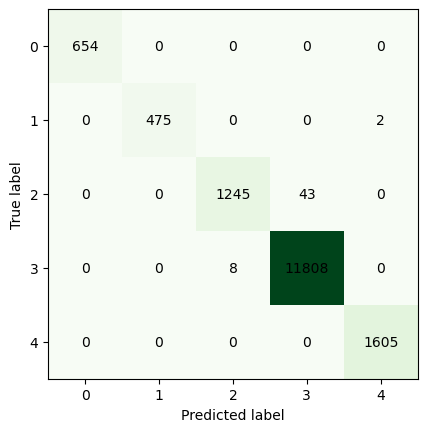

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

# Add labels to the plot
tick_marks = np.arange(len(conf_matrix))
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add values to the plot
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center')

# Show the plot
plt.show()

## Saving the model into a file

In [ ]:
import os

# saving the model
filename = "{}\\{}\\{}.h5".format(os.getcwd(), "MODELS\\[3-layer] - 3L1", _optimizer)
classifier.save(filename)

# PART 5 : Testing the Loaded Model

In [ ]:
from tensorflow.keras.models import load_model
filename = "{}\\{}\\{}.h5".format(os.getcwd(), "MODELS\\[3-layer] - 3L1", _optimizer)

# load model
loaded_model = load_model(filename)

## evaluate the model

In [ ]:
score = loaded_model.evaluate(X_test, Y_test)
print("Accuracy \t: {:.2f}".format(score[1]*100))
print("Loss \t\t: {:.2f}".format(score[0]*100))

# PART 5 : Trash Code

In [ ]:
# load the model to pickle file
filename = "{}\\{}\\{}.pickle".format(os.getcwd(), "MODELS\\[3-layer] - 3L1\\CV\\GridSearchCV", "best_model")
with open(filename, 'rb') as o:
    # dump information to that file
    data = pickle.load(o)

    # close the file
    file.close()

## Save the BEST Model

In [ ]:
import os
import pickle
filename = "{}\\{}\\{}.pickle".format(os.getcwd(), "MODELS\\[3-layer] - 3L1\\CV\\GridSearchCV", "best_model")
best_model = grid_result.best_estimator_

# save the model to pickle file
with open(filename, 'wb') as o:
    pickle.dump(best_model, o)
    # close the file
    o.close()
